### Created on 2025
### @author: S.W

## Policy Gradient (REINFORCE)

Policy Gradient의 핵심 아이디어:
- 정책을 신경망으로 직접 매개화
- 정책 매개변수를 경사 상승법으로 최적화
- 가치 함수 없이 정책만으로 학습 가능
- 연속 행동 공간에도 쉽게 적용

### 라이브러리 불러오기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import deque, namedtuple
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.unicode_minus'] = False

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

사용 장치: cuda


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


### 실습 환경 준비: CartPole-v1

In [2]:
# 간단한 CartPole 환경 구현 (gym 의존성 제거)
class CartPoleEnv:
   """
   간단한 CartPole 환경 구현
   
   카트 위에 막대가 있고, 카트를 좌우로 움직여서 막대가 넘어지지 않도록 하는 환경.
   물리 법칙을 따라 카트와 막대의 움직임을 시뮬레이션합니다.
   """
   
   def __init__(self):
       """
       CartPole 환경 초기화
       
       물리적 파라미터들과 임계값들을 설정합니다.
       """
       # 물리 파라미터들
       self.gravity = 9.8              # 중력 가속도 (m/s^2)
       self.masscart = 1.0             # 카트의 질량 (kg)
       self.masspole = 0.1             # 막대의 질량 (kg)
       self.total_mass = (self.masspole + self.masscart)  # 전체 질량
       self.length = 0.5               # 막대의 절반 길이 (m) - 회전 중심에서 질량 중심까지
       self.polemass_length = (self.masspole * self.length)  # 막대 질량 × 길이
       self.force_mag = 10.0           # 카트에 가해지는 힘의 크기 (N)
       self.tau = 0.02                 # 시간 간격 (초) - 물리 시뮬레이션 스텝 크기
       
       # 게임 오버 임계값들
       self.theta_threshold_radians = 12 * 2 * np.pi / 360  # ±12도를 라디안으로 변환
       self.x_threshold = 2.4          # 카트가 중심에서 ±2.4m 이상 벗어나면 게임 오버
       
       # 상태와 행동 공간 정의 (OpenAI Gym 스타일)
       self.observation_space = type('obj', (object,), {'shape': (4,)})()  # 4차원 상태 공간
       self.action_space = type('obj', (object,), {'n': 2})()              # 2개의 이산 행동
       
       # 현재 상태 변수
       self.state = None
       self.reset()
   
   def reset(self):
       """
       환경을 초기 상태로 리셋
       
       Returns:
           np.ndarray: 초기 상태 [x, x_dot, theta, theta_dot]
               - x: 카트의 위치 (-0.05 ~ 0.05)
               - x_dot: 카트의 속도 (-0.05 ~ 0.05)  
               - theta: 막대의 각도 (-0.05 ~ 0.05 라디안)
               - theta_dot: 막대의 각속도 (-0.05 ~ 0.05 라디안/초)
       """
       self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
       return self.state.copy()
   
   def step(self, action):
       """
       주어진 행동을 수행하고 환경을 한 스텝 진행
       
       Args:
           action (int): 수행할 행동
               - 0: 왼쪽으로 힘을 가함 (-10N)
               - 1: 오른쪽으로 힘을 가함 (+10N)
       
       Returns:
           tuple: (next_state, reward, done, info)
               - next_state (np.ndarray): 다음 상태 [x, x_dot, theta, theta_dot]
               - reward (float): 보상 (생존 시 1.0, 게임오버 시 0.0)
               - done (bool): 에피소드 종료 여부
               - info (dict): 추가 정보 (비어있음)
       """
       assert action in [0, 1], f"Invalid action {action}"
       
       # 현재 상태 분해
       x, x_dot, theta, theta_dot = self.state
       
       # 행동에 따른 힘 설정
       force = self.force_mag if action == 1 else -self.force_mag
       
       # 삼각함수 미리 계산 (성능 향상)
       costheta = np.cos(theta)
       sintheta = np.sin(theta)
       
       # 물리 법칙에 따른 가속도 계산
       # 복합 시스템의 운동방정식을 풀어서 얻은 공식들
       temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
       
       # 막대의 각가속도 계산
       thetaacc = (self.gravity * sintheta - costheta * temp) / (
           self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass)
       )
       
       # 카트의 가속도 계산
       xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
       
       # 오일러 적분법으로 상태 업데이트
       # v = v0 + a*dt, x = x0 + v*dt
       x = x + self.tau * x_dot
       x_dot = x_dot + self.tau * xacc
       theta = theta + self.tau * theta_dot
       theta_dot = theta_dot + self.tau * thetaacc
       
       # 새로운 상태 저장
       self.state = np.array([x, x_dot, theta, theta_dot])
       
       # 게임 오버 조건 확인
       done = bool(
           x < -self.x_threshold           # 카트가 너무 왼쪽으로
           or x > self.x_threshold         # 카트가 너무 오른쪽으로
           or theta < -self.theta_threshold_radians  # 막대가 너무 왼쪽으로 기울어짐
           or theta > self.theta_threshold_radians   # 막대가 너무 오른쪽으로 기울어짐
       )
       
       # 보상 계산: 생존하면 1점, 게임오버면 0점
       reward = 1.0 if not done else 0.0
       
       return self.state.copy(), reward, done, {}

# 환경 생성 및 정보 출력
env = CartPoleEnv()
print("✓ CartPole 환경 생성 완료")
print(f"상태 공간 차원: {env.observation_space.shape}")
print(f"행동 공간 크기: {env.action_space.n}")
print("상태: [위치, 속도, 각도, 각속도]")
print("행동: [왼쪽(0), 오른쪽(1)]")
print("목표: 막대를 넘어뜨리지 않고 최대한 오래 유지")

# 환경 동작 테스트
print("\n환경 테스트:")
test_state = env.reset()
print(f"초기 상태: {test_state}")
test_next_state, test_reward, test_done, _ = env.step(1)  # 오른쪽으로 힘을 가함
print(f"한 스텝 후 상태: {test_next_state}")
print(f"보상: {test_reward}, 종료: {test_done}")

✓ CartPole 환경 생성 완료
상태 공간 차원: (4,)
행동 공간 크기: 2
상태: [위치, 속도, 각도, 각속도]
행동: [왼쪽(0), 오른쪽(1)]
목표: 막대를 넘어뜨리지 않고 최대한 오래 유지

환경 테스트:
초기 상태: [0.01449003 0.02027815 0.04299223 0.00950735]
한 스텝 후 상태: [ 0.01489559  0.21475801  0.04318238 -0.26930706]
보상: 1.0, 종료: False


### 시각화 라이브러리 불러오기

In [3]:
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle
from IPython.display import HTML, display

# GIF 스타일 설정
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = 100
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 80

### 정책 네트워크 및 REINFORCE 알고리즘 정의

In [4]:
class PolicyNetwork(nn.Module):
   """
   정책 네트워크: 상태를 입력받아 각 행동의 확률을 출력하는 신경망
   
   강화학습에서 에이전트의 행동 선택 정책을 학습하는 신경망입니다.
   상태를 입력으로 받아서 각 행동을 선택할 확률을 출력합니다.
   """
   
   def __init__(self, state_size, action_size, hidden_size=128):
       """
       정책 네트워크 초기화
       
       Args:
           state_size (int): 입력 상태의 차원 (CartPole의 경우 4)
           action_size (int): 가능한 행동의 개수 (CartPole의 경우 2)
           hidden_size (int): 은닉층의 뉴런 개수 (기본값: 128)
       """
       super(PolicyNetwork, self).__init__()
       # 3층 완전연결 네트워크 구성
       self.fc1 = nn.Linear(state_size, hidden_size)    # 입력층 → 은닉층1
       self.fc2 = nn.Linear(hidden_size, hidden_size)   # 은닉층1 → 은닉층2  
       self.fc3 = nn.Linear(hidden_size, action_size)   # 은닉층2 → 출력층
       
   def forward(self, state):
       """
       순전파: 상태를 입력받아 행동 확률을 계산
       
       Args:
           state (torch.Tensor): 현재 상태 [batch_size, state_size]
           
       Returns:
           torch.Tensor: 각 행동의 확률 [batch_size, action_size]
       """
       x = F.relu(self.fc1(state))                      # ReLU 활성화로 비선형성 추가
       x = F.relu(self.fc2(x))                          # ReLU 활성화로 비선형성 추가
       action_probs = F.softmax(self.fc3(x), dim=-1)    # 소프트맥스로 확률 분포 변환
       return action_probs


class ImprovedREINFORCE:
   """
   REINFORCE 알고리즘: 정책 경사 방법을 사용한 강화학습 에이전트
   
   몬테카를로 방법을 사용하여 정책을 직접 학습하는 알고리즘입니다.
   에피소드가 끝난 후 받은 보상을 바탕으로 정책을 개선합니다.
   """
   
   def __init__(self, state_size, action_size, lr=0.001, gamma=0.99):
       """
       REINFORCE 에이전트 초기화
       
       Args:
           state_size (int): 상태 공간의 차원
           action_size (int): 행동 공간의 크기
           lr (float): 학습률 - 네트워크 가중치 업데이트 속도 조절
           gamma (float): 할인 인수 - 미래 보상의 현재 가치 비율 (0~1)
       """
       # 기본 설정
       self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       self.state_size = state_size
       self.action_size = action_size
       self.lr = lr              # 학습률: 너무 크면 불안정, 너무 작으면 학습 느림
       self.gamma = gamma        # 할인 인수: 1에 가까울수록 미래 보상을 중요하게 생각
       
       # 정책 네트워크와 옵티마이저 초기화
       self.policy_net = PolicyNetwork(state_size, action_size).to(self.device)
       self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
       
       # 에피소드별 데이터 저장소 초기화
       self.reset_episode()
       
       # 성능 모니터링용 리스트
       self.episode_rewards = []
       
   def reset_episode(self):
       """
       새로운 에피소드 시작 시 데이터 초기화
       
       각 에피소드마다 행동 확률과 보상을 새로 기록하기 위해 
       이전 에피소드의 데이터를 초기화합니다.
       """
       self.log_probs = []    # 선택한 행동들의 로그 확률값들
       self.rewards = []      # 환경에서 받은 보상들
       
   def select_action(self, state):
       """
       현재 상태에서 정책에 따라 행동 선택
       
       정책 네트워크가 출력한 확률 분포에 따라 행동을 확률적으로 선택합니다.
       이를 통해 탐험(exploration)과 활용(exploitation)의 균형을 맞춥니다.
       
       Args:
           state (np.ndarray): 현재 환경의 상태
           
       Returns:
           int: 선택된 행동 (0 또는 1)
       """
       # 상태를 PyTorch 텐서로 변환하고 배치 차원 추가 [1, state_size]
       state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
       
       # 정책 네트워크로 각 행동의 선택 확률 계산
       action_probs = self.policy_net(state)
       
       # 확률 분포를 만들어서 행동을 확률적으로 샘플링
       # 높은 확률의 행동이 더 자주 선택되지만, 낮은 확률의 행동도 가끔 선택됨
       dist = Categorical(action_probs)
       action = dist.sample()
       
       # 나중에 정책 업데이트할 때 사용할 log_prob 저장
       # log_prob는 선택한 행동의 로그 확률 (손실 함수 계산에 필요)
       self.log_probs.append(dist.log_prob(action))
       
       return action.item()  # 텐서에서 파이썬 정수로 변환하여 반환
   
   def store_reward(self, reward):
       """
       환경에서 받은 보상 저장
       
       매 스텝마다 환경에서 받은 보상을 저장합니다.
       에피소드 종료 후 이 보상들을 사용해 정책을 업데이트합니다.
       
       Args:
           reward (float): 현재 스텝에서 받은 보상
       """
       self.rewards.append(reward)
   
   def update_policy(self):
       """
       에피소드 종료 후 정책 네트워크 업데이트
       
       REINFORCE 알고리즘의 핵심 부분입니다.
       에피소드에서 받은 보상을 바탕으로 좋은 행동의 확률은 높이고,
       나쁜 행동의 확률은 낮추도록 정책 네트워크를 학습시킵니다.
       
       Returns:
           float: 계산된 정책 손실값 (모니터링용)
       """
       if len(self.rewards) == 0:
           return 0
           
       # 1단계: 할인된 누적 보상 계산 (Return 계산)
       # 미래의 보상일수록 현재 가치를 할인해서 계산
       discounted_rewards = []
       cumulative_reward = 0
       
       # 에피소드 끝에서부터 거꾸로 계산 (G_t = R_{t+1} + γ*G_{t+1})
       for reward in reversed(self.rewards):
           cumulative_reward = reward + self.gamma * cumulative_reward
           discounted_rewards.insert(0, cumulative_reward)
       
       # 2단계: 리스트를 PyTorch 텐서로 변환
       discounted_rewards = torch.FloatTensor(discounted_rewards).to(self.device)
       
       # 3단계: 보상 정규화 (학습 안정성 향상)
       # 평균을 빼고 표준편차로 나누어 분산을 줄임
       if len(discounted_rewards) > 1 and discounted_rewards.std() > 1e-8:
           discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
       
       # 4단계: 정책 손실 계산 
       # REINFORCE 공식: Loss = -log π(a_t|s_t) * G_t
       # 좋은 결과(높은 G_t)를 낸 행동의 확률은 높이고, 나쁜 결과를 낸 행동의 확률은 낮춤
       policy_loss = []
       for log_prob, G_t in zip(self.log_probs, discounted_rewards):
           # 음의 로그 확률 × 할인된 누적 보상 = 정책 경사 손실
           policy_loss.append(-log_prob * G_t)
       
       if policy_loss:
           # 모든 스텝의 손실을 합산
           policy_loss = torch.stack(policy_loss).sum()
           
           # 5단계: 역전파를 통한 네트워크 파라미터 업데이트
           self.optimizer.zero_grad()        # 이전 그래디언트 초기화
           policy_loss.backward()            # 역전파로 그래디언트 계산
           
           # 그래디언트 클리핑으로 그래디언트 폭발 방지
           torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
           
           self.optimizer.step()             # 계산된 그래디언트로 파라미터 업데이트
           
           loss_value = policy_loss.item()   # 모니터링용 손실값 추출
       else:
           loss_value = 0
       
       # 6단계: 다음 에피소드를 위해 현재 에피소드 데이터 초기화
       self.reset_episode()
       
       return loss_value

### REINFORCE 학습 및 테스트 함수 정의

In [5]:
def train_agent_properly(env, agent, num_episodes=1000, verbose=True):
    """
    REINFORCE 에이전트 학습 함수
    
    지정된 에피소드 수만큼 환경에서 에이전트를 학습시킵니다.
    각 에피소드마다 환경과 상호작용하고, 에피소드 종료 후 정책을 업데이트합니다.
    
    Args:
        env: 강화학습 환경 (CartPole 등)
        agent: 학습할 REINFORCE 에이전트
        num_episodes (int): 총 학습 에피소드 수
        verbose (bool): 학습 진행상황 출력 여부
        
    Returns:
        list: 각 에피소드별 총 보상 리스트
    """
    episode_rewards = []  # 각 에피소드의 총 보상을 저장할 리스트
    
    if verbose:
        print(f"Training REINFORCE agent ({num_episodes} episodes)")
        print("=" * 50)
    
    # 지정된 에피소드 수만큼 반복 학습
    for episode in range(num_episodes):
        # 환경 초기화 및 변수 설정
        state, info = env.reset()
        episode_reward = 0      # 현재 에피소드의 누적 보상
        done = False            # 에피소드 종료 플래그
        step_count = 0          # 현재 에피소드의 스텝 카운터
        max_steps = 500         # 무한 루프 방지를 위한 최대 스텝 제한
        
        # 에피소드 실행: 환경과 상호작용하며 경험 수집
        while not done and step_count < max_steps:
            # 현재 정책에 따라 행동 선택
            action = agent.select_action(state)
            
            # 선택한 행동을 환경에서 실행
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated  # 에피소드 종료 조건 (terminated 또는 truncated)
            
            # 받은 보상을 에이전트에 저장 (나중에 정책 업데이트에 사용)
            agent.store_reward(reward)
            episode_reward += reward
            
            # 다음 스텝을 위해 상태 업데이트
            state = next_state
            step_count += 1
        
        # 에피소드 종료 후 정책 업데이트 (REINFORCE의 핵심)
        # 수집한 경험을 바탕으로 정책 네트워크의 가중치를 조정
        loss = agent.update_policy()
        
        # 성능 기록
        episode_rewards.append(episode_reward)
        agent.episode_rewards.append(episode_reward)
        
        # 100 에피소드마다 학습 진행상황 출력
        if verbose and (episode + 1) % 100 == 0:
            recent_avg = np.mean(episode_rewards[-100:])  # 최근 100 에피소드 평균 성능
            print(f"Episode {episode + 1}: Recent 100 avg = {recent_avg:.2f}")
    
    if verbose:
        final_avg = np.mean(episode_rewards[-100:])
        print(f"Training complete! Final average: {final_avg:.2f}")
    
    return episode_rewards


def test_agent_performance(agent, env, num_tests=10):
    """
    학습된 에이전트의 성능을 테스트하는 함수
    
    학습이 완료된 에이전트가 얼마나 잘 수행하는지 여러 번 테스트해서
    평균 성능과 성능의 일관성을 확인합니다. 학습 중에는 탐험을 위해
    확률적으로 행동을 선택하지만, 테스트에서는 동일한 정책을 사용합니다.
    
    Args:
        agent: 테스트할 학습된 에이전트
        env: 테스트 환경
        num_tests (int): 테스트할 에피소드 수
        
    Returns:
        list: 각 테스트 에피소드별 총 보상 리스트
    """
    test_rewards = []  # 각 테스트 에피소드의 성능을 저장할 리스트
    
    # 지정된 횟수만큼 테스트 실행
    for test in range(num_tests):
        # 각 테스트마다 환경을 새로 초기화
        state, info = env.reset()
        total_reward = 0        # 현재 테스트 에피소드의 총 보상
        done = False            # 에피소드 종료 플래그
        step = 0                # 스텝 카운터
        max_steps = 500         # 최대 스텝 제한
        
        # 에피소드가 끝날 때까지 또는 최대 스텝에 도달할 때까지 실행
        while not done and step < max_steps:
            # 학습된 정책에 따라 행동 선택 (여전히 확률적 선택)
            action = agent.select_action(state)
            
            # 행동 실행 및 결과 관찰
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            state = next_state
            total_reward += reward
            step += 1
        
        # 이번 테스트의 총 보상 기록
        test_rewards.append(total_reward)
    
    return test_rewards

### CartPole 애니메이션 함수 정의

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle

class CartPoleAnimator:
    """
    CartPole 환경에서 에이전트의 플레이를 애니메이션으로 시각화하는 클래스
    
    에이전트가 실제로 환경에서 어떻게 행동하는지 시각적으로 확인할 수 있는
    애니메이션을 생성합니다. 카트의 움직임, 막대의 기울어짐, 에이전트의 행동 선택
    등을 실시간으로 보여줍니다.
    """
    
    def __init__(self, title="CartPole", figsize=(10, 6)):
        """
        애니메이터 초기화
        
        Args:
            title (str): 애니메이션 제목
            figsize (tuple): 그림 크기 (가로, 세로)
        """
        self.title = title
        self.figsize = figsize
        
        # 에피소드 데이터
        self.states = []      # 각 스텝의 환경 상태
        self.actions = []     # 각 스텝에서 에이전트가 선택한 행동
        self.total_reward = 0
        
        # 시각적 요소들 (나중에 초기화)
        self.fig = None
        self.ax = None
        self.cart = None
        self.pole_line = None
        self.pole_tip = None
        self.step_text = None
        self.action_text = None
        self.angle_text = None
    
    def collect_episode_data(self, agent, env, max_frames=200):
        """
        에이전트가 한 에피소드를 플레이하면서 모든 상태와 행동을 기록
        
        Args:
            agent: 학습된 REINFORCE 에이전트
            env: CartPole 환경
            max_frames (int): 최대 프레임 수 (에피소드 길이 제한)
        """
        # 데이터 초기화
        self.states = []
        self.actions = []
        self.total_reward = 0
        
        # 에피소드 시작
        state, info = env.reset()
        done = False
        step = 0
        
        # 에이전트가 에피소드를 플레이하며 데이터 수집
        while not done and step < max_frames:
            # 현재 상태 저장 (애니메이션에서 사용할 데이터)
            self.states.append(np.array(state).copy())
            
            # 에이전트가 현재 상태를 보고 행동 결정
            # 학습된 정책 네트워크가 상태를 분석해서 확률적으로 행동 선택
            action = agent.select_action(state)
            self.actions.append(action)  # 선택한 행동 기록 (애니메이션에서 표시용)
            
            # 선택한 행동을 환경에서 실행하고 결과 관찰
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            state = next_state
            self.total_reward += reward
            step += 1
        
        print(f"Animation episode: {len(self.states)} steps, Reward: {self.total_reward}")
    
    def setup_animation_canvas(self):
        """
        애니메이션 캔버스와 시각적 요소들을 설정
        """
        # 캔버스 생성
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.fig.patch.set_facecolor('white')
        
        # 좌표계 설정 (CartPole 환경에 맞게)
        self.ax.set_xlim(-2.5, 2.5)    # 카트가 움직일 수 있는 x 범위
        self.ax.set_ylim(-0.3, 2.2)    # y 범위 (바닥부터 막대 끝까지)
        self.ax.set_aspect('equal')     # 비율 맞춤
        self.ax.grid(True, alpha=0.3, color='gray')
        self.ax.set_facecolor('lightblue')
        
        # 고정 정보: 제목과 에피소드 요약
        title_text = self.ax.text(0, 1.9, self.title, ha='center', fontsize=16, 
                                 fontweight='bold', color='darkblue')
        info_text = self.ax.text(0, 1.7, f'Steps: {len(self.states)} | Reward: {self.total_reward:.0f}', 
                                ha='center', fontsize=12, color='darkgreen')
        
        # 동적 정보: 매 프레임마다 업데이트되는 실시간 정보
        self.step_text = self.ax.text(-2.2, -0.2, '', fontsize=12, fontweight='bold', color='blue')
        self.action_text = self.ax.text(1.5, -0.2, '', fontsize=12, fontweight='bold', color='red')
        self.angle_text = self.ax.text(0, -0.2, '', fontsize=10, color='purple')
        
        # CartPole 시각적 요소 생성
        self._create_cartpole_elements()
    
    def _create_cartpole_elements(self):
        """
        CartPole의 시각적 요소들 (카트, 막대, 바닥) 생성
        """
        # 카트: 직사각형으로 표현
        self.cart = Rectangle((-0.4, 0), 0.8, 0.25, fc='navy', ec='black', alpha=0.9, linewidth=2)
        
        # 막대: 선으로 표현 (카트 중심에서 막대 끝까지)
        self.pole_line, = self.ax.plot([], [], linewidth=8, solid_capstyle='round')
        
        # 막대 끝: 원으로 표현 (질량 중심을 시각화)
        self.pole_tip = Circle((0, 0), 0.1, fc='red', ec='black', linewidth=2, alpha=0.9)
        
        # 바닥: 수평선으로 표현
        self.ax.axhline(y=0, color='brown', linewidth=4, alpha=0.8)
        
        # 요소들을 축에 추가
        self.ax.add_patch(self.cart)
        self.ax.add_patch(self.pole_tip)
    
    def get_pole_status(self, theta):
        """
        막대 각도에 따른 위험도 상태 반환
        
        Args:
            theta (float): 막대 각도 (라디안)
            
        Returns:
            tuple: (색상, 상태 메시지)
        """
        angle_deg = abs(theta * 180 / np.pi)  # 라디안을 각도로 변환
        
        if angle_deg > 20:          # 매우 위험: 곧 넘어질 것 같음
            return 'darkred', 'DANGER!'
        elif angle_deg > 12:        # 위험: 게임오버 임계점 근처
            return 'red', 'Warning'
        elif angle_deg > 8:         # 주의: 조심스러운 상태
            return 'orange', 'Careful'
        else:                       # 안전: 안정적인 상태
            return 'green', 'Stable'
    
    def update_frame(self, frame):
        """
        각 프레임에서 CartPole의 상태를 업데이트
        
        수집된 상태 데이터와 행동 데이터를 바탕으로 매 프레임마다
        카트의 위치, 막대의 각도, 에이전트의 행동을 시각적으로 표현합니다.
        
        Args:
            frame (int): 현재 프레임 번호 (0부터 시작)
            
        Returns:
            tuple: 업데이트된 시각적 요소들
        """
        # 프레임 범위 확인
        if frame >= len(self.states):
            return self.cart, self.pole_line, self.pole_tip, self.step_text, self.action_text, self.angle_text
        
        # 현재 프레임의 상태 데이터 가져오기
        x_pos, x_vel, theta, theta_vel = self.states[frame]
        
        # 카트 위치 업데이트
        # 카트의 x 좌표에 따라 카트 직사각형의 위치 조정
        self.cart.set_x(x_pos - 0.4)  # 카트 중심이 x_pos가 되도록 조정
        
        # 막대 위치 계산 및 업데이트
        pole_length = 1.3  # 막대의 시각적 길이
        
        # 막대는 카트 중심에서 시작해서 theta 각도로 뻗어나감
        # 물리학: x = r*sin(θ), y = r*cos(θ) (θ=0일 때 수직)
        pole_x = x_pos + pole_length * np.sin(theta)      # 막대 끝의 x 좌표
        pole_y = 0.125 + pole_length * np.cos(theta)      # 막대 끝의 y 좌표 (카트 높이 0.125 추가)
        
        # 막대 선 업데이트: 카트 중심에서 막대 끝까지
        self.pole_line.set_data([x_pos, pole_x], [0.125, pole_y])
        
        # 막대 끝 원 위치 업데이트
        self.pole_tip.center = (pole_x, pole_y)
        
        # 막대 각도에 따른 위험도 시각화
        color, status = self.get_pole_status(theta)
        
        # 막대와 막대 끝의 색상 업데이트
        self.pole_line.set_color(color)
        self.pole_tip.set_facecolor(color)
        
        # 실시간 정보 텍스트 업데이트
        self._update_info_texts(frame, theta, status)
        
        return self.cart, self.pole_line, self.pole_tip, self.step_text, self.action_text, self.angle_text
    
    def _update_info_texts(self, frame, theta, status):
        """
        실시간 정보 텍스트들을 업데이트
        
        Args:
            frame (int): 현재 프레임
            theta (float): 막대 각도 (라디안)
            status (str): 막대 상태 메시지
        """
        # 현재 스텝 정보
        self.step_text.set_text(f'Step: {frame+1}/{len(self.states)}')
        
        # 에이전트가 선택한 행동 표시
        # actions[frame]: 0이면 왼쪽 힘, 1이면 오른쪽 힘
        action_str = "⬅ LEFT" if self.actions[frame] == 0 else "➡ RIGHT"
        self.action_text.set_text(action_str)
        
        # 막대 각도와 안정성 상태
        angle_deg = abs(theta * 180 / np.pi)
        self.angle_text.set_text(f'Angle: {angle_deg:.1f}° ({status})')
    
    def create_animation(self, agent, env, max_frames=200, interval=80, repeat=True):
        """
        전체 애니메이션 생성 프로세스
        
        Args:
            agent: 학습된 REINFORCE 에이전트
            env: CartPole 환경
            max_frames (int): 최대 프레임 수
            interval (int): 프레임 간 간격 (밀리초)
            repeat (bool): 애니메이션 반복 여부
            
        Returns:
            tuple: (애니메이션 객체, 총 보상)
        """
        # 1단계: 에이전트 플레이 데이터 수집
        self.collect_episode_data(agent, env, max_frames)
        
        # 2단계: 애니메이션 캔버스 설정
        self.setup_animation_canvas()
        
        # 3단계: 애니메이션 생성
        anim = animation.FuncAnimation(
            self.fig, self.update_frame,     # 매 프레임마다 호출할 메서드
            frames=len(self.states),         # 총 프레임 수 (수집된 상태 개수)
            interval=interval,               # 프레임 간 간격 (밀리초) - 80ms = 12.5 FPS
            blit=False,                      # 전체 다시 그리기 (더 안정적)
            repeat=repeat                    # 애니메이션 반복 재생
        )
        
        plt.tight_layout()
        return anim, self.total_reward


# 사용 예시 함수 (기존 함수와의 호환성 유지)
def create_gif_style_animation(agent, env, title="CartPole", max_frames=200):
    """
    기존 함수와의 호환성을 위한 래퍼 함수
    
    Args:
        agent: 학습된 REINFORCE 에이전트
        env: CartPole 환경  
        title (str): 애니메이션 제목
        max_frames (int): 최대 프레임 수
        
    Returns:
        tuple: (애니메이션 객체, 총 보상)
    """
    animator = CartPoleAnimator(title=title)
    return animator.create_animation(agent, env, max_frames=max_frames)

### 1. 랜덤 에이전트 정의 및 테스트

In [7]:
class RandomAgent:
    def select_action(self, state):
        return np.random.choice(2)

random_agent = RandomAgent()

In [8]:
print("=" * 70)
print("RELIABLE CARTPOLE LEARNING DEMO Start")
print("=" * 70)

# 환경 생성
env = gym.make('CartPole-v1')

RELIABLE CARTPOLE LEARNING DEMO Start


In [9]:
print("1. Testing Random Agent (10 episodes)...")
random_performance = test_agent_performance(random_agent, env, 10)
random_avg = np.mean(random_performance)
random_std = np.std(random_performance)
print(f"   Random Agent: {random_avg:.1f} ± {random_std:.1f} steps")

# 애니메이션 생성만 하고 표시하지 않기
plt.ioff()  # 대화형 모드 끄기

print("\nCreating Random Agent Animation...")
random_anim, random_episode_reward = create_gif_style_animation(
    random_agent, env, "RANDOM AGENT"
)
plt.close()  # 현재 figure 닫기
plt.ion()   # 대화형 모드 다시 켜기

print("Displaying Random Agent:")
display(random_anim)

1. Testing Random Agent (10 episodes)...
   Random Agent: 17.6 ± 6.2 steps

Creating Random Agent Animation...
Animation episode: 8 steps, Reward: 8.0
Displaying Random Agent:


### 2. REINFORCE 알고리즘 학습

In [10]:
# 2. 학습된 에이전트
print(f"\n2. Training REINFORCE Agent...")
trained_agent = ImprovedREINFORCE(4, 2, lr=0.001, gamma=0.99)

# 더 많은 에피소드로 확실히 학습
training_rewards = train_agent_properly(env, trained_agent, num_episodes=500, verbose=True)


2. Training REINFORCE Agent...
Training REINFORCE agent (500 episodes)
Episode 100: Recent 100 avg = 34.89
Episode 200: Recent 100 avg = 155.17
Episode 300: Recent 100 avg = 321.48
Episode 400: Recent 100 avg = 253.54
Episode 500: Recent 100 avg = 349.31
Training complete! Final average: 349.31


### 3. REINFORCE 알고리즘 결과 애니메이션 시각화

In [11]:
print(f"3. Testing Trained Agent (10 episodes)...")
trained_performance = test_agent_performance(trained_agent, env, 10)
trained_avg = np.mean(trained_performance)
trained_std = np.std(trained_performance)
print(f"   Trained Agent: {trained_avg:.1f} ± {trained_std:.1f} steps")

# 애니메이션 생성만 하고 표시하지 않기
plt.ioff()  # 대화형 모드 끄기

print(f"\n   Creating Trained Agent Animation...")
trained_anim, trained_episode_reward = create_gif_style_animation(
    trained_agent, env, "TRAINED AGENT"
)

plt.close()  # 현재 figure 닫기
plt.ion()   # 대화형 모드 다시 켜기

print("   Displaying Trained Agent:")
display(trained_anim)

3. Testing Trained Agent (10 episodes)...
   Trained Agent: 462.7 ± 83.8 steps

   Creating Trained Agent Animation...
Animation episode: 200 steps, Reward: 200.0
   Displaying Trained Agent:


### 4. 랜덤 에이전트 vs REINFORCE 알고리즘 에이전트

In [12]:
print(f"" + "="*70)
print("RESULTS ANALYSIS")
print("="*70)
print(f"Random Agent Performance:")
print(f"  Average: {random_avg:.1f} ± {random_std:.1f} steps")
print(f"  Range: {min(random_performance):.0f} - {max(random_performance):.0f} steps")

print(f"\nTrained Agent Performance:")
print(f"  Average: {trained_avg:.1f} ± {trained_std:.1f} steps")
print(f"  Range: {min(trained_performance):.0f} - {max(trained_performance):.0f} steps")

improvement = trained_avg - random_avg
print(f"\nImprovement: {improvement:.1f} steps ({improvement/random_avg*100:.1f}% increase)")

if improvement > 50:
    print("✅ Training was SUCCESSFUL!")
elif improvement > 20:
    print("⚠️ Training showed some improvement")
else:
    print("❌ Training needs more work")

RESULTS ANALYSIS
Random Agent Performance:
  Average: 17.6 ± 6.2 steps
  Range: 10 - 31 steps

Trained Agent Performance:
  Average: 462.7 ± 83.8 steps
  Range: 228 - 500 steps

Improvement: 445.1 steps (2529.0% increase)
✅ Training was SUCCESSFUL!


### 5. 학습 곡선 시각화

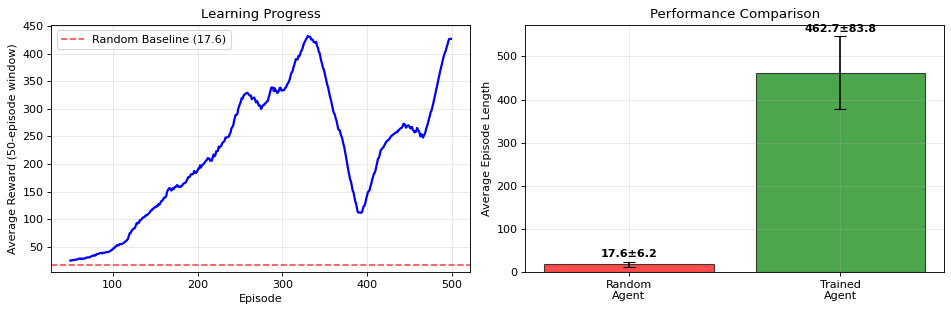

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
window_size = 50
if len(training_rewards) >= window_size:
    moving_avg = []
    for i in range(window_size, len(training_rewards)):
        moving_avg.append(np.mean(training_rewards[i-window_size:i]))
    
    plt.plot(range(window_size, len(training_rewards)), moving_avg, 'b-', linewidth=2)
    plt.axhline(y=random_avg, color='red', linestyle='--', alpha=0.7,
               label=f'Random Baseline ({random_avg:.1f})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (50-episode window)')
    plt.title('Learning Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
agents = ['Random\nAgent', 'Trained\nAgent']
means = [random_avg, trained_avg]
stds = [random_std, trained_std]

bars = plt.bar(agents, means, yerr=stds, capsize=5,
               color=['red', 'green'], alpha=0.7, edgecolor='black')
plt.ylabel('Average Episode Length')
plt.title('Performance Comparison')
plt.grid(True, alpha=0.3)

# 막대 위에 수치 표시
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 5,
             f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

env.close()

### 🚀 최신 알고리즘 발전

Policy Gradient 계열
- PPO (Proximal Policy Optimization): 안정적인 정책 업데이트
- TRPO (Trust Region Policy Optimization): 신뢰 영역 기반 학습
- A3C (Asynchronous Advantage Actor-Critic): 비동기 병렬 학습

### 실무 팁

#### 하이퍼파라미터 튜닝

중요한 하이퍼파라미터들
- learning_rate = [1e-4, 3e-4, 1e-3] -> 가장 중요! 너무 크면 불안정, 너무 작으면 느린 수렴
- gamma = [0.95, 0.99, 0.999]        -> 환경에 따라 조정
- network_size = [64, 128, 256]      -> 문제 복잡도에 맞게, 과소적합 vs 과적합의 균형
- 배치 크기                           -> 메모리 효율성과 학습 안정성


#### 재현 가능한 실험
시드 고정으로 재현성 확보
- torch.manual_seed(42)
- np.random.seed(42)
- random.seed(42)

### ✓ 실습 성과:
- CartPole 환경에서 3가지 알고리즘 구현
- PyTorch 기반 신경망 구조 이해
- 각 방법의 학습 특성과 성능 비교
- 하이퍼파라미터 영향도 분석